In [1]:
pip install pandas numpy scikit-learn matplotlib deap


Note: you may need to restart the kernel to use updated packages.


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    269252
           1       1.00      0.99      0.99     80889

    accuracy                           1.00    350141
   macro avg       1.00      1.00      1.00    350141
weighted avg       1.00      1.00      1.00    350141

False Negatives: 672
False Positives: 176
Accuracy Score: 0.9975781185293925


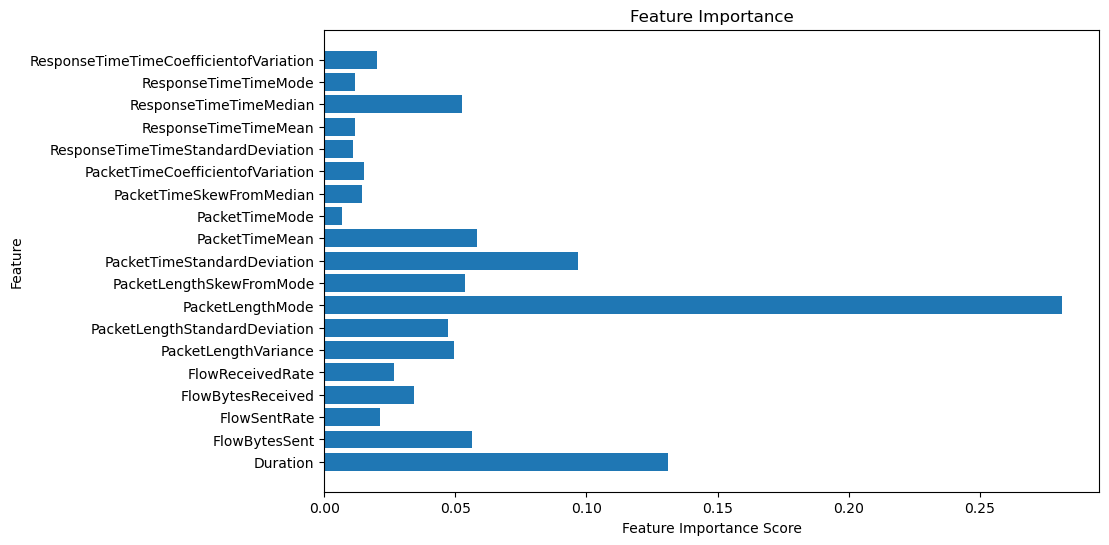

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms

# Load datasets
doh_df = pd.read_csv('l1-doh.csv')
nondoh_df = pd.read_csv('l1-nondoh.csv')

# Combine datasets
df = pd.concat([doh_df, nondoh_df])

# Drop unnecessary columns
df.drop(columns=['SourceIP', 'DestinationIP', 'SourcePort', 'DestinationPort', 'TimeStamp'], inplace=True)

# Encode labels
df['Label'] = df['Label'].map({'DoH': 1, 'NonDoH': 0})

# Split data into features and target
X = df.drop(columns=['Label'])
y = df['Label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the genetic algorithm function for feature selection
def genetic_algorithm_feature_selection(X_train, y_train, num_generations=20, population_size=50):
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    toolbox.register("attr_bool", np.random.randint, 0, 2)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=len(X_train.columns))
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    def eval_individual(individual):
        selected_features = [i for i in range(len(individual)) if individual[i] == 1]
        if len(selected_features) == 0:
            return 0,
        X_train_selected = X_train.iloc[:, selected_features]
        clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        clf.fit(X_train_selected, y_train)
        return clf.score(X_train_selected, y_train),

    toolbox.register("evaluate", eval_individual)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
    toolbox.register("select", tools.selTournament, tournsize=3)

    population = toolbox.population(n=population_size)
    algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=num_generations, verbose=False)

    best_individual = tools.selBest(population, k=1)[0]
    return best_individual

best_individual = genetic_algorithm_feature_selection(X_train, y_train)
selected_features = [i for i in range(len(best_individual)) if best_individual[i] == 1]

# Train Random Forest Classifier with selected features
X_train_selected = X_train.iloc[:, selected_features]
X_test_selected = X_test.iloc[:, selected_features]
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(X_train_selected, y_train)
y_pred = clf.predict(X_test_selected)

# Output classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
false_negatives = cm[1, 0]
false_positives = cm[0, 1]
print(f"False Negatives: {false_negatives}")
print(f"False Positives: {false_positives}")

# Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy}")

# Plot feature importance
feature_importances = clf.feature_importances_
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.barh(range(len(selected_features)), feature_importances, align='center')
plt.yticks(range(len(selected_features)), X_train.columns[selected_features])
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.show()
